# Python Experience Level: Logistique Regression, LDA, KNN, SVM

In [2]:
import pandas as pd
import numpy as np
import copy
import random
import itertools
%matplotlib inline
import matplotlib.pyplot as plt
import time

### Fonction utiles et recuperation des données 

Ici changer chemin accès DATADIR_UCI et SIGNALS 

In [3]:
## LIBRARIES
import seaborn as sns

from sklearn.model_selection import train_test_split


randomseed = 1234

## DATA LOADING AND PREPROCESSING
# Load the data
gym = pd.read_csv('../../gym_members_exercise_tracking.csv')

# set 'Gender', 'Workout_Type', 'Workout_Frequency (days/week)' and 'Experience_Level' as categorical
for col in ['Gender', 'Workout_Type', 'Workout_Frequency (days/week)', 'Experience_Level']:
    gym[col] = gym[col].astype('category')

# log transform Weight and BMI
gym['Weight (kg)'] = np.log1p(gym['Weight (kg)'])

# transform 'Fat_Percentage'
max_fat = gym['Fat_Percentage'].max()
gym['Fat_Percentage'] = gym['Fat_Percentage'].apply(lambda x: np.sqrt(max_fat+1)-x)

# rename transformed columns
gym.rename(columns={'Weight (kg)': 'LWeight', 'Fat_Percentage': 'SFat_Percentage'}, inplace=True)

gym.drop(columns=['BMI'], inplace=True)

# divide into train and test set
gym_train, gym_test = train_test_split(gym, test_size=0.2, random_state=randomseed)

# Create gym_train_scale, gym_test_scale
gym_train_scale = gym_train.copy()
gym_test_scale = gym_test.copy()

# Scale the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
gym_train_scale[['LWeight', 'Height (m)', 'Max_BPM', 'Avg_BPM', 'Resting_BPM', 'Session_Duration (hours)',
                             'Water_Intake (liters)', 'SFat_Percentage', 'Workout_Frequency (days/week)', 'Calories_Burned']] = scaler.fit_transform(gym_train_scale[['LWeight', 'Height (m)', 'Max_BPM', 'Avg_BPM', 'Resting_BPM', 'Session_Duration (hours)',
                             'Water_Intake (liters)', 'SFat_Percentage', 'Workout_Frequency (days/week)', 'Calories_Burned']])

gym_test_scale[['LWeight', 'Height (m)', 'Max_BPM', 'Avg_BPM', 'Resting_BPM', 'Session_Duration (hours)',
                             'Water_Intake (liters)', 'SFat_Percentage', 'Workout_Frequency (days/week)', 'Calories_Burned']] = scaler.transform(gym_test_scale[['LWeight', 'Height (m)', 'Max_BPM', 'Avg_BPM', 'Resting_BPM', 'Session_Duration (hours)',
                             'Water_Intake (liters)', 'SFat_Percentage', 'Workout_Frequency (days/week)', 'Calories_Burned']])


# Create X_train_exp_level, X_test_exp_level, y_train_exp_level, y_test_exp_level
X_train_exp_level = gym_train.drop(columns=['Experience_Level'])
X_train_exp_level_scale = gym_train_scale.drop(columns=['Experience_Level'])
y_train_exp_level = gym_train['Experience_Level']
X_test_exp_level = gym_test.drop(columns=['Experience_Level'])
X_test_exp_level_scale = gym_test_scale.drop(columns=['Experience_Level'])
y_test_exp_level = gym_test['Experience_Level']

# Create X_train_calories, X_test_calories, y_train_calories, y_test_calories
X_train_calories = gym_train.drop(columns=['Calories_Burned'])
X_train_calories_scale = gym_train_scale.drop(columns=['Calories_Burned'])
y_train_calories = gym_train['Calories_Burned']
X_test_calories = gym_test.drop(columns=['Calories_Burned'])
X_test_calories_scale = gym_test_scale.drop(columns=['Calories_Burned'])
y_test_calories = gym_test['Calories_Burned']

print("Data loaded and preprocessed")

Data loaded and preprocessed


In [85]:
print(X_test_exp_level_scale)

     Age  Gender   LWeight  Height (m)   Max_BPM   Avg_BPM  Resting_BPM  \
40    31  Female -1.367641   -1.679753  1.327567 -0.916129    -0.283251   
394   40    Male  0.977844    1.568419  0.716570  0.881297    -0.283251   
219   36    Male  1.568830    0.331020  0.978426  0.812165     1.649810   
677   40  Female -1.098841   -0.519692  1.589423 -1.676579     1.235583   
883   29  Female -1.352989   -1.215728 -1.029136 -0.846998    -1.249781   
..   ...     ...       ...         ...       ...       ...          ...   
61    51  Female -1.673714   -0.751704  1.589423 -0.501339     0.959431   
782   39  Female -0.874024   -0.983716  0.367428  0.466506     0.959431   
706   34    Male  1.640443    0.949719 -1.552848 -0.708734     0.545204   
857   53  Female -0.371507   -1.370403  1.240281 -0.363075    -0.007099   
512   30  Female -0.674360   -0.751704 -0.505425 -0.224812     1.649810   

     Session_Duration (hours)  Calories_Burned Workout_Type  SFat_Percentage  \
40                 

changer dictionnaire activités et signals

In [4]:
# Liste des couleurs
CMAP = plt.get_cmap("Accent")
# Liste des types de signaux
SIGNALS = ["LWeight", "Height (m)", "Max_BPM", "Avg_BPM", "Resting_BPM", "Session_Duration (hours)",
                             "Water_Intake (liters)", "SFat_Percentage", "Workout_Frequency (days/week)", "Calories_Burned"]
 
# tableau des niveaux d'expérience (contexte supervisé)
EXP_LEVEL_TAB = [1, 2, 3] #[1, 2, 3]
labels=["niveau 1","niveau 2","niveau 3"] #labels = ACTIVITY_DIC.values()

# Fonction pour le tracé d'un signal
# def plot_one_axe(X, fig, ax, sample_to_plot, cmap):
#     for act,Xgb in X.groupby("Activity"):
#         Xgb_first_values = Xgb.values[:sample_to_plot,:-1]
#         x = Xgb_first_values[0]
#         ax.plot(x, linewidth=1, color=cmap(act-1), label = label_dic[act])
#         for x in Xgb_first_values[1:]:
#             ax.plot(x, linewidth=1, color=cmap(act-1))

# Fonction pour le tracé d'un signal en fonction du niveau d'expérience
def plot_one_axe(X, fig, ax, sample_to_plot, cmap):
    for exp_level, Xgb in X.groupby("Experience_Level"):
        Xgb_first_values = Xgb.values[:sample_to_plot, :-1]
        x = Xgb_first_values[0]
        ax.plot(x, linewidth=1, color=cmap(exp_level-1), label=f"Experience Level {exp_level}")
        for x in Xgb_first_values[1:]:
            ax.plot(x, linewidth=1, color=cmap(exp_level-1))

# def plot_one_axe_shuffle(X, fig, ax, sample_to_plot, cmap):
#     plot_data = []
#     for act,Xgb in X.groupby("Activity"):
#         Xgb_first_values = Xgb.values[:sample_to_plot,:-1]
#         x = Xgb_first_values[0]
#         ax.plot(x, linewidth=1, color=cmap(act-1), label = label_dic[act])
#         for x in Xgb_first_values[1:]:
#             plot_data.append([x,cmap(act-1)])
#     random.shuffle(plot_data)
#     for x,color in plot_data:
#         ax.plot(x, linewidth=1, color=color)

def plot_one_axe_shuffle(X, fig, ax, sample_to_plot, cmap):
    plot_data = []
    for exp_level,Xgb in X.groupby("Experience_Level"):
        Xgb_first_values = Xgb.values[:sample_to_plot,:-1]
        x = Xgb_first_values[0]
        ax.plot(x, linewidth=1, color=cmap(exp_level-1), label = f"Experience Level {exp_level}")
        for x in Xgb_first_values[1:]:
            plot_data.append([x,cmap(exp_level-1)])
    random.shuffle(plot_data)
    for x,color in plot_data:
        ax.plot(x, linewidth=1, color=color)

### Création des différents formats de données 

In [5]:

N_train = X_train_exp_level.shape[0]
N_test = X_test_exp_level.shape[0]

In [88]:
print("Dimension")
print("Données unidimensionelles, : " + str(X_train_exp_level.shape))
print("Données Normalisées, : " + str(X_train_exp_level_scale.shape))
print("Vecteur réponse (scikit-learn) : " + str(y_train_exp_level.shape))
#print("Matrice réponse(Keras) : " + str(y_train_exp_level.shape))

Dimension
Données unidimensionelles, : (778, 13)
Données Normalisées, : (778, 13)
Vecteur réponse (scikit-learn) : (778,)


## Regression logistique 

####  Principe
Une méthode statistique ancienne mais finalement efficace sur ces données. La régression logistique est adaptée à la prévision d'une variable binaire. Dans le cas multiclasse, la fonction logistique de la librairie `Scikit-learn` estime *par défaut* **un modèle par classe**: une classe contre les autres. 

La probabilité d'appartenance d'un individu à une classe est modélisée à l'aide d'une combinaison linéaire des variables explicatives. Pour transformer une combinaison linéaire à valeur dans $R$ en une probabilité à valeurs dans l'intervalle $[0, 1]$, une fonction de forme sigmoïdale est appliquée.  Ceci donne: $$P(y_i=1)=\frac{e^{Xb}}{1+e^{Xb}}$$ ou, c'est équivalent, une décomposition linéaire du *logit* ou *log odd ratio* de  $P(y_i=1)$:  $$\log\frac{P(y_i=1)}{1-P(y_i=1)}=Xb.$$

### Estimation sans optimisation / sans régularisation

In [6]:
X_train_exp_level_dummies = pd.get_dummies(X_train_exp_level, drop_first=True)
X_test_exp_level_dummies = pd.get_dummies(X_test_exp_level, drop_first=True)

print(X_train_exp_level_dummies)
print(X_train_exp_level_dummies.shape)
print(X_train_exp_level.shape)

     Age   LWeight  Height (m)  Max_BPM  Avg_BPM  Resting_BPM  \
718   51  4.756173        1.67      189      139           55   
811   27  4.503137        1.87      169      153           62   
366   42  4.348987        1.97      165      157           65   
737   34  4.756173        1.81      181      167           67   
813   34  4.094345        1.62      178      150           56   
..   ...       ...         ...      ...      ...          ...   
204   23  4.440296        1.99      179      130           71   
53    21  4.581902        1.72      161      151           62   
294   44  4.503137        1.99      192      135           58   
723   51  3.918005        1.61      191      129           55   
815   39  4.855929        1.82      180      161           70   

     Session_Duration (hours)  Calories_Burned  SFat_Percentage  \
718                      1.38            950.0            -18.4   
811                      1.62           1363.0             -6.7   
366               

In [7]:
from sklearn.linear_model import LogisticRegression
ts = time.time()
for solver in ['liblinear','lbfgs', 'saga', 'sag', 'newton-cg']:
    method = LogisticRegression(solver=solver ,multi_class='auto')  #lbfgs, saga, sag, newton-cg
    method.fit(X_train_exp_level_dummies,y_train_exp_level)
    score = method.score(X_test_exp_level_dummies, y_test_exp_level)
    ypred = method.predict(X_test_exp_level_dummies)
    te = time.time()

    from sklearn.metrics import confusion_matrix, accuracy_score
    print("Score : %f, time running : %d secondes" %(score, te-ts))
    pd.DataFrame(confusion_matrix(y_test_exp_level, ypred), index = labels, columns=labels)

Score : 0.902564, time running : 0 secondes
Score : 0.789744, time running : 0 secondes
Score : 0.733333, time running : 0 secondes
Score : 0.748718, time running : 0 secondes


c:\Users\LiLi\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\LiLi\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\LiLi\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Score : 0.897436, time running : 0 secondes


c:\Users\LiLi\anaconda3\Lib\site-packages\sklearn\utils\optimize.py:211: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(


In [8]:
from sklearn.linear_model import LogisticRegression
ts = time.time()
method = LogisticRegression(solver='liblinear' ,multi_class='auto')  #lbfgs, saga, sag, newton-cg
method.fit(X_train_exp_level_dummies,y_train_exp_level)
score = method.score(X_test_exp_level_dummies, y_test_exp_level)
ypred = method.predict(X_test_exp_level_dummies)
te = time.time()


Une fois le modèle estimé, l'erreur de prévision est évaluée, sans biais optimiste, sur un autre échantillon, dit échantillon test, qui n'a pas participé à l'apprentissage du modèle.

In [9]:
from sklearn.metrics import confusion_matrix, accuracy_score
print("Score : %f, time running : %d secondes" %(score, te-ts))
pd.DataFrame(confusion_matrix(y_test_exp_level, ypred), index = labels, columns=labels)

Score : 0.902564, time running : 0 secondes


,niveau 1,niveau 2,niveau 3
niveau 1,70,8,0
niveau 2,11,68,0
niveau 3,0,0,38


Interprétation: les classes "niveau 1" et "niveau 2", qui correspondent au niveaux d'experiences faibles et moyens sont difficcile à discriminer. Les resultats sont cohérent avec l'approche exploratoire: les niveau d'expérience 1 et 2 sont "proches", difficiles à discriminer. 
Les autres options de solver ne convergent pas.  

### Optimisation du modèle par pénalisation Lasso

In [10]:
# Optimisation du paramètre de pénalisation
# grille de valeurs
from sklearn.model_selection import GridSearchCV
ts = time.time()
param=[{"C":[ 0.5, 1, 5, 10, 30, 100, 200]}]   #[0.5,1,5,10,12,15,30] [0.1, 0.5, 1, 2, 5, 10, 20]
logit = GridSearchCV(LogisticRegression(penalty="l1",solver='liblinear', 
                                        multi_class='auto'), param,cv=10,n_jobs=-1)
logitOpt=logit.fit(X_train_exp_level_dummies, y_train_exp_level)  
# paramètre optimal
logitOpt.best_params_["C"]
te = time.time()
print("Temps : %d secondes" %(te-ts))

Temps : 13 secondes


In [11]:
print("Meilleur score = %f, Meilleur paramètre = %s" % (logitOpt.best_score_,logitOpt.best_params_)) #score apprentisage 

Meilleur score = 0.855961, Meilleur paramètre = {'C': 1}


les meilleur pararmètre est C=1 ce qui correspond à la valeur par default dans la fonction, on retrouve donc les memes résultats: la matrice de confusion et l'erreure de prévision sont les memes que pour la regression logistique non optimisée.  

In [12]:
yChap = logitOpt.predict(X_test_exp_level_dummies)
# matrice de confusion
logitOpt.score(X_test_exp_level_dummies, y_test_exp_level)  #score généralisation= prédiction 

0.9025641025641026

In [13]:
pd.DataFrame(confusion_matrix(y_test_exp_level, yChap), index = labels, columns=labels)

,niveau 1,niveau 2,niveau 3
niveau 1,70,8,0
niveau 2,11,68,0
niveau 3,0,0,38


=> voir quels variables selectionnées par methode Lasso (code ozone: recup coef et ordonnés)

L'interprétation nécessite de connaître les valeurs des coefficients du modèle alors que l'objet `regLassOpt` issu de `GridSearchCV` ne retient pas les paramètres estimés. Il faut donc le ré-estimer avec la valeur optimale du paramètre de pénalisation si l'on souhaite afficher ces coefficients.

In [14]:

logit=LogisticRegression(penalty="l1",solver='liblinear', 
                                        multi_class='auto', C=logitOpt.best_params_['C'])
model_lasso=logit.fit(X_train_exp_level_dummies, y_train_exp_level)
model_lasso.coef_

array([[-4.41472353e-03,  3.18350433e-01,  2.07812562e-01,
         3.57866988e-03,  3.37878224e-02, -6.11229637e-03,
         0.00000000e+00, -5.77230180e-03, -5.94445893e-02,
         2.77856841e-01,  0.00000000e+00,  4.70760741e-03,
         0.00000000e+00, -1.22077131e-01, -3.81704433e+00,
        -8.86896907e+00, -5.33940505e+00],
       [ 3.00083844e-03, -5.08799330e-01, -1.15128259e+00,
        -9.66948175e-03, -1.40277356e-02, -1.42602588e-02,
        -5.75009704e-04,  2.12091392e-03, -2.82142814e-01,
        -1.37303384e+00,  2.93413479e+00,  0.00000000e+00,
        -1.68507000e-01,  4.86269158e-02,  4.29292194e+00,
         6.75353149e+00,  0.00000000e+00],
       [ 2.10043909e-02,  0.00000000e+00,  0.00000000e+00,
         1.09197170e-01, -1.50756222e-01,  5.66845797e-02,
         0.00000000e+00,  2.33249886e-02,  1.97771685e+00,
         0.00000000e+00, -1.46191852e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.0

In [15]:
# Coefficients du modèle Lasso
coefs = model_lasso.coef_

# Compter le nombre de coefficients non nuls pour chaque classe
non_zero_coefs_per_class = np.sum(coefs != 0, axis=1)

# Afficher le nombre de coefficients non nuls par classe
for i, count in enumerate(non_zero_coefs_per_class):
    print(f"Classe {i+1} : {count} coefficients non nuls")

Classe 1 : 14 coefficients non nuls
Classe 2 : 15 coefficients non nuls
Classe 3 : 7 coefficients non nuls


Dans les classes 1 et 2, deux coefficients sont enlevés et dans la classe 3, 10. 

Variables sélectionnées et triées (moyenne des coefficients) :
SFat_Percentage                    0.545376
Gender_Male                        0.490739
Workout_Frequency (days/week)_3    0.158626
Max_BPM                            0.034369
Resting_BPM                        0.012104
Calories_Burned                    0.006558
Age                                0.006530
Workout_Type_HIIT                  0.001569
Session_Duration (hours)          -0.000192
Workout_Type_Yoga                 -0.024483
Avg_BPM                           -0.043665
Workout_Type_Strength             -0.056169
LWeight                           -0.063483
Height (m)                        -0.314490
Water_Intake (liters)             -0.365059
Workout_Frequency (days/week)_4   -0.705146
Workout_Frequency (days/week)_5   -1.779802
dtype: float64


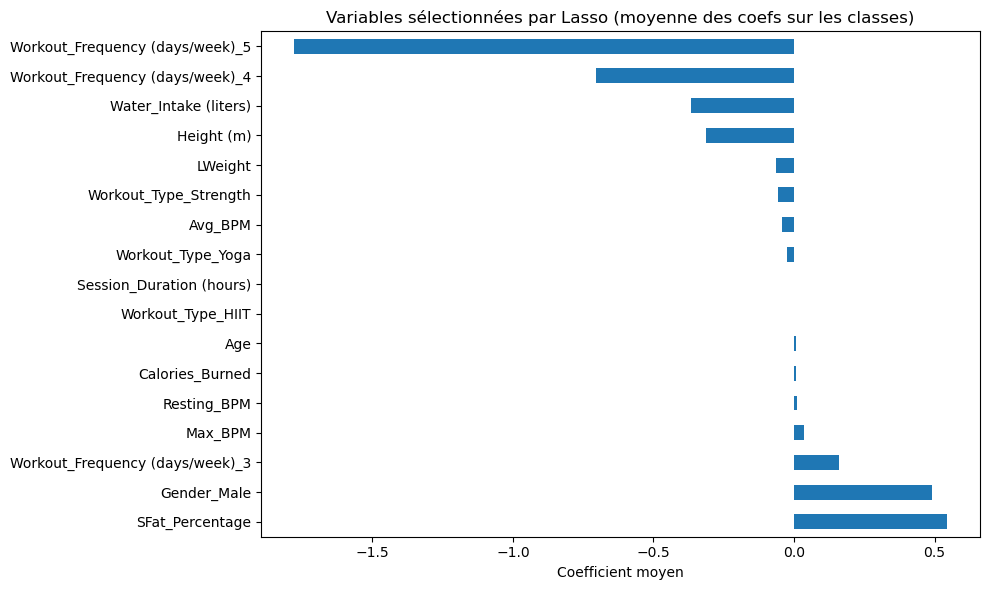

In [ ]:
# Récupérer les coefficients
coefs = model_lasso.coef_  # array de shape (n_classes, n_features)

# Transformer les coefficients en DataFrame
coef_df = pd.DataFrame(coefs, columns=X_train_exp_level_dummies.columns)  # colonnes = noms des variables
coef_df.index = [f"Class_{i}" for i in range(coefs.shape[0])]  # index = classes

# Trouver les variables utilisées (au moins une fois ≠ 0 dans une classe)
coef_used = (coef_df != 0).any(axis=0)  # un mask booléen sur les colonnes
selected_coefs = coef_df.loc[:, coef_used]

# Calculer la moyenne par variable et trier
mean_coefs = selected_coefs.mean(axis=0).sort_values(ascending=False)

# 7. Afficher
print("Variables sélectionnées et triées (moyenne des coefficients) :")
print(mean_coefs)

# 8. Visualiser
mean_coefs.plot(kind='barh', figsize=(10,6))
plt.title("Variables sélectionnées par Lasso (moyenne des coefs sur les classes)")
plt.xlabel("Coefficient moyen")
plt.tight_layout()
plt.show()


Cette analyse nous permet de voir quelles variables ont le plus grand impact sur la classe cible et lesquelles sont relativement sans effet: Les variables comme SFat_Percentage et Gender_Male augmentent la probabilité d'appartenir à la classe cible, tandis que des variables comme Workout_Frequency (days/week)_5, Height (m), et Water_Intake (liters) la diminuent. 

### Analyse Discriminante linéaire  

In [21]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis

ts=time.time()

method=LinearDiscriminantAnalysis()
method.fit(X_train_exp_level_dummies, y_train_exp_level)
score = method.score(X_test_exp_level_dummies,y_test_exp_level)
ypred = method.predict(X_test_exp_level_dummies)
te=time.time()
t_total = te-ts
score 

0.9076923076923077

In [22]:
print("Score : %f, time running : %d secondes" %(score, t_total))
pd.DataFrame(confusion_matrix(y_test_exp_level, ypred), index=labels, columns= labels)

Score : 0.907692, time running : 0 secondes


,niveau 1,niveau 2,niveau 3
niveau 1,70,8,0
niveau 2,10,69,0
niveau 3,0,0,38


Interprétation: erreur de généralisation 0.097 pas mal
presque meme répartition qu'avec la regression logistique, 1 erreure de moins. On retrouve que les individus du niveau sont tjr "faciles" à iddentifier, alors que les niveau 1 et 2 sont plus souvent confondus entre eux. 

## K plus proches voisins 

Cas particulier d'analyse discriminante avec estimation locale des fonctions de densité conditionnelle . 

In [23]:
from sklearn.neighbors import KNeighborsClassifier
ts=time.time()
method=KNeighborsClassifier(n_jobs=-1)
method.fit(X_train_exp_level_dummies, y_train_exp_level)
score = method.score(np.array(X_test_exp_level_dummies),y_test_exp_level)
ypred = method.predict(np.array(X_test_exp_level_dummies))
te=time.time()
t_total = te-ts

c:\Users\LiLi\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
c:\Users\LiLi\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


In [24]:
print("Score : %f, time running : %d secondes" %(score, te-ts))
pd.DataFrame(confusion_matrix(y_test_exp_level, ypred), index = labels, columns=labels)

Score : 0.717949, time running : 0 secondes


,niveau 1,niveau 2,niveau 3
niveau 1,47,31,0
niveau 2,18,61,0
niveau 3,1,5,32


Le score opbtenu est beaucoup moins bon qu'avec les methodes (blabla) utilisés précédement, cependant le temps d'execution est très rapide. Le nombre de voisin utilisés par défaut est 5, nous allons tenter d'optimiser ce paramètre. 

In [25]:
from sklearn.model_selection import GridSearchCV
ts=time.time()

param_grid = {'n_neighbors': list(range(1, 16))}  # Tester de 1 à 15 voisins

method=KNeighborsClassifier(n_jobs=-1)
kn= GridSearchCV(method, param_grid, cv=10, scoring='accuracy')# recherche par validation croisée
knOpt=kn.fit(np.array(X_train_exp_level_dummies), y_train_exp_level)  # Assurez-vous que X_train_np est bien un np.array

te=time.time()
t_total=te-ts

print("Meilleur nombre de voisins :", knOpt.best_params_['n_neighbors']) #paramètre trouvé 
print("Meilleure score en validation croisée :", knOpt.best_score_) #score généralisation 

Meilleur nombre de voisins : 11
Meilleure score en validation croisée : 0.6954878454878455


In [26]:
yChap=knOpt.predict(np.array(X_test_exp_level_dummies))
pd.DataFrame(confusion_matrix(y_test_exp_level, yChap), index = labels, columns=labels)

,niveau 1,niveau 2,niveau 3
niveau 1,47,28,3
niveau 2,12,64,3
niveau 3,0,7,31


interpretation: score mauvais, beaucoup d'erreur de classement 

## SVM lineaire 

le nombre de voisins considérés k optimal est 11, cependant on obtient une erreure d'apprentissage plus grande qu'avec k=5=> du à la validation croisée? 
Le temps de calcul est très long: 26s contre 0s, cette améloration n'est pas rentable. 

In [27]:
from sklearn.svm import SVC
ts = time.time()
method = SVC(kernel='linear',gamma='auto')
method.fit(X_train_exp_level_dummies,y_train_exp_level)
score = method.score(X_test_exp_level_dummies, y_test_exp_level)
ypred = method.predict(X_test_exp_level_dummies)
te = time.time()

In [28]:
print("Score : %f, time running : %d secondes" %(score, te-ts))
pd.DataFrame(confusion_matrix(y_test_exp_level, ypred), index = labels, columns=labels)

Score : 0.912821, time running : 3 secondes


,niveau 1,niveau 2,niveau 3
niveau 1,68,10,0
niveau 2,7,72,0
niveau 3,0,0,38


pas mal meme sans optimisation

In [37]:
ts = time.time()
param=[{"C":[4,5,6],"gamma":[.01,.02,.03]}]
svm= GridSearchCV(SVC(kernel='linear'),param,cv=10,n_jobs=-1)
svmOpt=svm.fit(X_train_exp_level_dummies, y_train_exp_level)
te = time.time()
te-ts

481.630446434021

TEMPS D'EXECTUTIOn TRESSSS LONG 

In [38]:
# paramètre optimal
print("Meilleur score = %f, Meilleur paramètre = %s" % (svmOpt.best_score_,svmOpt.best_params_))

Meilleur score = 0.863786, Meilleur paramètre = {'C': 4, 'gamma': 0.01}


In [39]:
yChap=svmOpt.predict(np.array(X_test_exp_level_dummies))
pd.DataFrame(confusion_matrix(y_test_exp_level, yChap), index = labels, columns=labels)

c:\Users\LiLi\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


,niveau 1,niveau 2,niveau 3
niveau 1,69,9,0
niveau 2,10,69,0
niveau 3,0,0,38


la prédiction n'est pas meilleurs et le temps d'excution bien trop élevé.

comparaison svm linéaire: (vs radiale)
temps de calcul:
performance:  

### SVM radiale 

In [32]:

ts = time.time()
method = SVC(kernel='rbf',gamma='auto')
method.fit(X_train_exp_level_dummies,y_train_exp_level)
score = method.score(X_test_exp_level_dummies, y_test_exp_level)
ypred = method.predict(X_test_exp_level_dummies)
te = time.time()

In [33]:
print("Score : %f, time running : %d secondes" %(score, te-ts))
pd.DataFrame(confusion_matrix(y_test_exp_level, ypred), index = labels, columns=labels)

Score : 0.405128, time running : 0 secondes


,niveau 1,niveau 2,niveau 3
niveau 1,0,78,0
niveau 2,0,79,0
niveau 3,0,38,0


nul nul nul
on essaie d'optimiser les paramètres C et gamma

In [34]:
ts = time.time()
param=[{"C":[4,5,6],"gamma":[.01,.02,.03]}]
svm= GridSearchCV(SVC(),param,cv=10,n_jobs=-1)
svmOpt=svm.fit(X_train_exp_level_dummies, y_train_exp_level)
te = time.time()
te-ts

4.803318977355957

In [35]:
# paramètre optimal
print("Meilleur score = %f, Meilleur paramètre = %s" % (svmOpt.best_score_,svmOpt.best_params_))

Meilleur score = 0.521845, Meilleur paramètre = {'C': 4, 'gamma': 0.01}


In [36]:
yChap=svmOpt.predict(np.array(X_test_exp_level_dummies))
pd.DataFrame(confusion_matrix(y_test_exp_level, yChap), index = labels, columns=labels)

c:\Users\LiLi\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


,niveau 1,niveau 2,niveau 3
niveau 1,44,34,0
niveau 2,25,54,0
niveau 3,3,33,2


toujours beaucoup d'erreurs. La prédiction est toujours mauvaise, mais elle a nettement améliorer avec l'optimisation des paramètre: certains individus sont prédit dans les cathegories 1 et 3. L'erreur de généralisation reste de 50%.  Le temps d'execution est plus raisonnable que pour ll'optimisation des paramètre de la svm linéaire

Finalement c'est la svm linéaire sans optimisation des paramètres qui est la plus adapté à notre problème de classification. 